# DynamicHMCExamples for DynamicHMC.jl v2.0.0

黒木玄

2019-08-26～2019-09-03

2019年9月3日に

```
pkg> add LogDensityProblems
pkg> add DynamicHMC
```

した状態で

https://github.com/tpapp/DynamicHMCExamples.jl/tree/master/src

にあるexamplesを動くようにしたノートブック.

DynamicHMC.jl は v2.0.0 から仕様が大幅に変化するので, 現在公開されているexamplesがそのままでは動かない.  それを修正してみたのが, このノートブックです.

## 追記
[Introduction to Bayesian Statistics.ipynb](https://github.com/genkuroki/Statistics/blob/master/Introduction%20to%20Bayesian%20Statistics.ipynb)で「Bayes統計の計算例」として最後に引用されています。

上記のノートブックの記述を詳しくしました。
特に適当に翻訳をつけつつ、コードを簡単に分解してコメントから小タイトルをつけています。

`mathcodes/julia`ディレクトリ直下の`pkgs.jl`を実行すると必要なパッケージがすべてインストールできます。

[上記グラフの解釈](#上記グラフの解釈)は他のノートブックから引用されていて、そこにもコメントの追記があります。

# Table of Contents
- [1 Bernoulli](#Bernoulli)
- [2  Logistic regression](#Logistic-regression)
- [3  Linear regression](#Linear-regression)

## ライブラリ読み込み・関数定義

In [1]:
using Distributions
using TransformVariables
using LogDensityProblems
using DynamicHMC
using DynamicHMC.Diagnostics
using MCMCDiagnostics
using Parameters
using Statistics
using Random
using Plots
gr(size=(400, 250), titlefontsize=12)
using ForwardDiff
using StatsFuns
using LinearAlgebra

using Base64
showimg(mime, fn) = open(fn) do f
    base64 = base64encode(f)
    display("text/html", """<img src="data:$mime;base64,$base64">""")
end

showimg (generic function with 1 method)

## Bernoulli

- [オリジナルのファイル](https://github.com/tpapp/DynamicHMCExamples.jl/blob/master/src/example_independent_bernoulli.jl)

> We estimate a simple model of ``n`` independent Bernoulli draws, with
> probability ``α``. First, we load the packages we use.

確率$\alpha$の$n$個の独立なベルヌーイ試行を評価します。

### データを保持する構造体の定義

> Then define a structure to hold the data.
> For this model, the number of draws equal to `1` is a sufficient statistic.

このモデルに対して1に等しいドローの数は十分統計量です。

In [2]:
"""
Toy problem using a Bernoulli distribution.
We model `n` independent draws from a ``Bernoulli(α)`` distribution.
"""
struct BernoulliProblem
    "Total number of draws in the data."
    n::Int
    "Number of draws `==1` in the data"
    s::Int
end

BernoulliProblem

### 関数定義
> Then make the type callable with the parameters *as a single argument*.  We
> use decomposition in the arguments, but it could be done inside the function, too.

関数のパラメータに構造体を渡して内部で分解して呼び出します。

In [3]:
function (problem::BernoulliProblem)((α, )::NamedTuple{(:α, )})
    @unpack n, s = problem        # extract the data
    # log likelihood: the constant log(combinations(n, s)) term
    # has been dropped since it is irrelevant to sampling.
    s * log(α) + (n-s) * log(1-α)
end

### 関数のテスト
> We should test this, also, this would be a good place to benchmark and
> optimize more complicated problems.

In [4]:
p = BernoulliProblem(30, 10)
p((α = 0.5, ))

-20.79441541679836

### 注意
> Recall that we need to
>
> 1. transform from $\mathbb{R}$ to the valid parameter domain `(0,1)` for more efficient sampling, and
>
> 2. calculate the derivatives for this transformed mapping.
>
> The helper packages `TransformVariables` and `LogDensityProblems` take care of
> this. We use a flat prior (the default, omitted)

#### [TransformedLogDensity](https://tamaspapp.eu/LogDensityProblems.jl/dev/#LogDensityProblems.TransformedLogDensity)
> TransformedLogDensity(transformation, log_density_function)

>A problem in Bayesian inference. Vectors of length compatible with the dimension (obtained from transformation) are transformed into a general object θ (unrestricted type, but a named tuple is recommended for clean code), correcting for the log Jacobian determinant of the transformation.

#### [ADgradient](https://tamaspapp.eu/LogDensityProblems.jl/dev/#LogDensityProblems.ADgradient)
> automatic differentiation to obtain a gradient.

In [5]:
trans = as((α = as𝕀,))
P = TransformedLogDensity(trans, p)
∇P = ADgradient(:ForwardDiff, P);

### 事後分布の確認
> Finally, we sample from the posterior. `chain` holds the chain (positions and
> diagnostic information), while the second returned value is the tuned sampler
> which would allow continuation of sampling.

もちろん`L`がウォームアップ期間。
ウォームアップなどについてはMCMCを詳しく勉強すること。
簡単に言うと、収束したとみなせるまでのトライアル回数を指す。

In [6]:
L = 1000
results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, L; reporter = NoProgressReport());

### $\alpha$に対する事後分布の評価
> To get the posterior for ``α``, we need to use `get_position` and then transform

[事後の$\alpha$のグラフ](#事後の$\alpha$のグラフ)のところでグラフを描くのでそれまで概要の確認は待っていてください。

In [7]:
#posterior = transform.(Ref(t), get_position.(chain));
posterior = transform.(trans, results.chain)
typeof(posterior) |> print 

Array{NamedTuple{(:α,),Tuple{Float64}},1}

### パラメータの抽出
> Extract the parameter.

`NamedTuple`で返ってくるので$\alpha$を取り出します。

In [8]:
posterior_α = first.(posterior)
#Y = [p.α for p in posterior]
typeof(posterior_α) |> print

Array{Float64,1}

### 平均の確認
> check the mean

In [9]:
mean(posterior_α)

0.33554947912630617

### 有効サンプルサイズの確認
> check the effective sample size

事前情報が持っているサンプルサイズのこと。

In [10]:
ess_α = effective_sample_size(posterior_α)

346.79575269261926

### 地域統計分類単位
> NUTS-specific statistics

- [URL: Wikipedia](https://ja.wikipedia.org/wiki/%E5%9C%B0%E5%9F%9F%E7%B5%B1%E8%A8%88%E5%88%86%E9%A1%9E%E5%8D%98%E4%BD%8D)

> 地域統計分類単位（ちいきとうけいぶんるいたんい、フランス語: Nomenclature d'unités territoriales statistiques、英語: Nomenclature of Territorial Units for Statistics[1] もしくは Nomenclature of Units for Territorial Statistics[2]、略称:NUTS）は、欧州連合（EU）で用いられている、統計のための地方区画の標準規格である。

In [11]:
#NUTS_statistics(chain)
summarize_tree_statistics(results.tree_statistics)

Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.93, 5/25/50/75/95%: 0.71 0.89 0.97 1.0 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 66%, 2 => 34%

### 事後の$\alpha$のグラフ


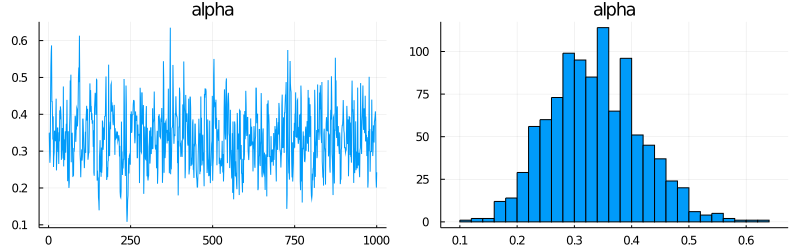

In [12]:
P1 = plot(posterior_α)
P2 = histogram(posterior_α)
plot(P1, P2, size=(800, 250), title="alpha", legend=false)

pngname = "images/001_01_posterior_alpha_hist.png"
savefig(pngname)
showimg("image/png", pngname)

## Logistic regression

- [オリジナルのコード](https://github.com/tpapp/DynamicHMCExamples.jl/blob/master/src/example_logistic_regression.jl)

### 構造体の定義

In [13]:
"""
Logistic regression.
For each draw, ``logit(Pr(yᵢ == 1)) ∼ Xᵢ β``. Uses a `β ∼ Normal(0, σ)` prior.
`X` is supposed to include the `1`s for the intercept.
"""
struct LogisticRegression{Ty, TX, Tσ}
    y::Ty
    X::TX
    σ::Tσ
end

LogisticRegression

### 基本的な処理関数の定義

In [14]:
function (problem::LogisticRegression)(θ)
    @unpack y, X, σ = problem
    @unpack β = θ
    # 対数尤度
    loglik = sum(logpdf.(Bernoulli.(logistic.(X*β)), y))
    # 事前分布の対数
    logpri = sum(logpdf.(Ref(Normal(0, σ)), β))
    loglik + logpri
end

### パラメータの生成
> Make up parameters, generate data using random draws.

In [15]:
N = 1000
β = [1.0, 2.0]
X = hcat(ones(N), randn(N))
y = rand.(Bernoulli.(logistic.(X*β)));

### Problem作成

> Create a problem, apply a transformation, then use automatic differentiation.

Problemを作ってから変換し、自動微分します。

In [16]:
p = LogisticRegression(y, X, 10.0)   # data and (vague) priors
typeof(p) |> print

LogisticRegression{BitArray{1},Array{Float64,2},Float64}

### 自動微分

In [17]:
trans = as((β = as(Array, length(β)), )) # identity transformation, just to get the dimension
P = TransformedLogDensity(trans, p)      # transformed
∇P = ADgradient(:ForwardDiff, P)

ForwardDiff AD wrapper for TransformedLogDensity of dimension 2, w/ chunk size 2

### NUTSを使ったサンプリング
> Sample using NUTS, random starting point.

In [18]:
#chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);
L = 10^3
@time results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, L; reporter = NoProgressReport());

  4.524015 seconds (5.21 M allocations: 676.553 MiB, 6.39% gc time)


### 事後分布の抽出
> Extract the posterior. Here the transformation was not really necessary.

これもグラフは[β_posteriorの図示](#β_posteriorの図示)で確認します。

In [19]:
posterior = transform.(trans, results.chain)
typeof(posterior) |> print

Array{NamedTuple{(:β,),Tuple{Array{Float64,1}}},1}

### $\beta$の抜き出し

In [20]:
β_posterior = first.(posterior)
typeof(β_posterior) |> print

Array{Array{Float64,1},1}

### パラメータが復元できるか確認
> Check that we recover the parameters.

In [21]:
mean(β_posterior)

2-element Array{Float64,1}:
 0.8286287656810079
 1.9046089602817404

### 分位数
> Quantiles

In [22]:
qs = [0.05, 0.25, 0.5, 0.75, 0.95]
quantile(first.(β_posterior), qs)

5-element Array{Float64,1}:
 0.6807932375902006
 0.7675887317307057
 0.8292856000844292
 0.887305217045035
 0.9736724568552401

In [23]:
quantile(last.(β_posterior), qs)

5-element Array{Float64,1}:
 1.6986842518161651
 1.8196427532158015
 1.9042784783401636
 1.9823197077750152
 2.1157428521167985

### よい混合か確認
> Check that mixing is good.

In [24]:
ess = vec(mapslices(effective_sample_size, reduce(hcat, β_posterior); dims = 2))

2-element Array{Float64,1}:
 675.5105820030192
 682.8201174511023

### `β_posterior`の図示


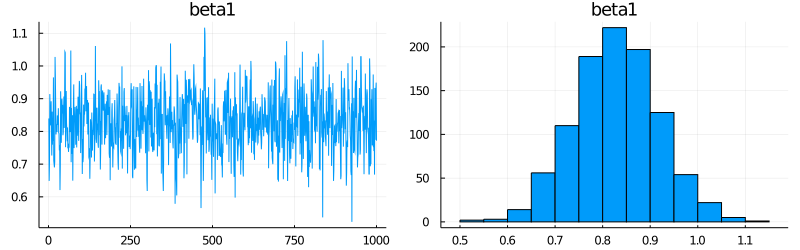

In [25]:
P1 = plot(first.(β_posterior))
P2 = histogram(first.(β_posterior))
plot(P1, P2, size=(800, 250), title="beta1", legend=false)

pngname = "images/001_02_posterior_beta1.png"
savefig(pngname)
showimg("image/png", pngname)


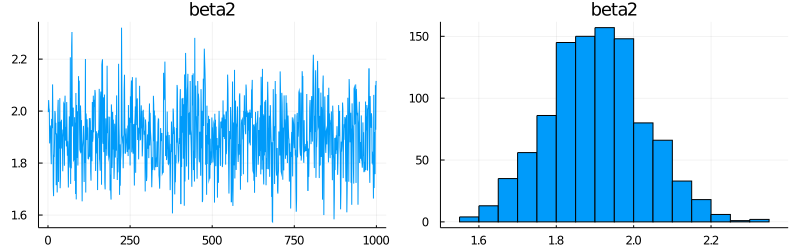

In [26]:
P1 = plot(last.(β_posterior))
P2 = histogram(last.(β_posterior))
plot(P1, P2, size=(800, 250), title="beta2", legend=false)

pngname = "images/001_03_posterior_beta2.png"
savefig(pngname)
showimg("image/png", pngname)

## Linear regression

- [オリジナルのコード](https://github.com/tpapp/DynamicHMCExamples.jl/blob/master/src/example_linear_regression.jl)

In [27]:
Random.seed!(4649);

### 構造体の定義
> We estimate simple linear regression model with a half-T prior.
> Then define a structure to hold the data: observables, covariates, and the degrees of freedom for the prior.

In [28]:
"""
Linear regression model ``y ∼ Xβ + ϵ``, where ``ϵ ∼ N(0, σ²)`` IID.
Flat prior for `β`, half-T for `σ`.
"""
struct LinearRegressionProblem{TY <: AbstractVector, TX <: AbstractMatrix,
                               Tν <: Real}
    "Observations."
    y::TY
    "Covariates"
    X::TX
    "Degrees of freedom for prior."
    ν::Tν
end

LinearRegressionProblem

### 関数定義
> Then make the type callable with the parameters *as a single argument*.

In [29]:
function (problem::LinearRegressionProblem)(θ)
    @unpack y, X, ν = problem   # extract the data
    @unpack β, σ = θ            # works on the named tuple too
    loglikelihood(Normal(0, σ), y .- X*β) + logpdf(TDist(ν), σ)
end

### テスト
> We should test this, also, this would be a good place to benchmark and
> optimize more complicated problems.

### 計算に使うデータ設定

In [30]:
#N = 100
N = 5
#X = hcat(ones(N), randn(N, 2));
x = rand(Uniform(-2, 2), N)
X = hcat(ones(N), x, x.^2);
β = [1.0, 2.0, -1.0]
#σ = 0.5
σ = 1.0
y = X*β .+ randn(N) .* σ;
p = LinearRegressionProblem(y, X, 1.0);
p((β = β, σ = σ))

-8.66067388411468

### `law_true`の定義：二次関数

In [31]:
law_true(β, x) = β[1] + β[2]*x + β[3]*x^2

law_true (generic function with 1 method)

### 変換結果を返す
> For this problem, we write a function to return the transformation (as it varies with the number of covariates).

In [32]:
problem_transformation(p::LinearRegressionProblem) =
    as((β = as(Array, size(p.X, 2)), σ = asℝ₊))

problem_transformation (generic function with 1 method)

### 確認
> Wrap the problem with a transformation, then use Flux for the gradient

In [33]:
trans = problem_transformation(p)
P = TransformedLogDensity(trans, p)
∇P = ADgradient(:ForwardDiff, P);

### 事後分布からサンプリング
> Finally, we sample from the posterior. `chain` holds the chain (positions and
> diagnostic information), while the second returned value is the tuned sampler
> which would allow continuation of sampling.

### MCMCで計算

In [34]:
L = 2^11

#chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);
@time results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, L; reporter = NoProgressReport());
typeof(results.chain) |> print

  3.583841 seconds (5.52 M allocations: 343.021 MiB, 4.83% gc time)
Array{Array{Float64,1},1}

### 処理
> We use the transformation to obtain the posterior from the chain.

`chain`から事後分布を得るために変換します。
これまでと同じく[グラフ描画：真の法則とサンプルの比較](#グラフ描画：真の法則とサンプルの比較)でグラフを描くので必要なら先に見てきてください。

In [35]:
#posterior = transform.(Ref(t), get_position.(chain));
posterior = transform.(trans, results.chain)
typeof(posterior) |> print

Array{NamedTuple{(:β, :σ),Tuple{Array{Float64,1},Float64}},1}

### `β`の抽出
> Extract the parameter posterior means: `β`,

In [36]:
posterior_β = first.(posterior)
@show mean_posterior_β = mean(posterior_β)

mean_posterior_β = mean(posterior_β) = [1.9487574305092665, 2.630170460545854, -1.3616126952300904]


3-element Array{Float64,1}:
  1.9487574305092665
  2.630170460545854
 -1.3616126952300904

### `σ`の抽出

In [37]:
posterior_σ = last.(posterior)
@show mean_posterior_σ = mean(posterior_σ)

typeof(posterior_β) |> print
typeof(posterior_σ) |> print

mean_posterior_σ = mean(posterior_σ) = 1.0342901486692764
Array{Array{Float64,1},1}Array{Float64,1}

### 無変換drawsの有効サンプルサイズ
> Effective sample sizes (of untransformed draws)

In [38]:
ess = mapslices(effective_sample_size, hcat(results.chain...); dims = 2)

4×1 Array{Float64,2}:
 465.17584376216666
 693.780359318295
 571.0351798191298
 142.41445087647367

### 地域統計分類単位
> NUTS-specific statistics

In [39]:
#NUTS_statistics(chain)
summarize_tree_statistics(results.tree_statistics)

Hamiltonian Monte Carlo sample of length 2048
  acceptance rate mean: 0.87, 5/25/50/75/95%: 0.34 0.87 0.96 0.99 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 1%, 2 => 11%, 3 => 44%, 4 => 41%, 5 => 3%, 6 => 0%

### グラフ描画：真の法則とサンプルの比較


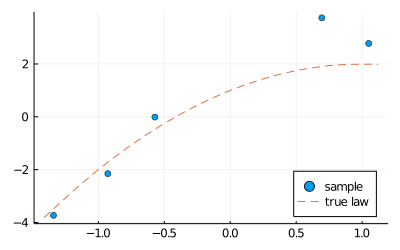

In [40]:
scatter(X[:,2], y, label="sample", legend=:bottomright)
plot!(x -> law_true(β, x), label="true law", ls=:dash)

pngname = "images/001_04_true_law.png"
savefig(pngname)
showimg("image/png", pngname)

### グラフ描画 beta1


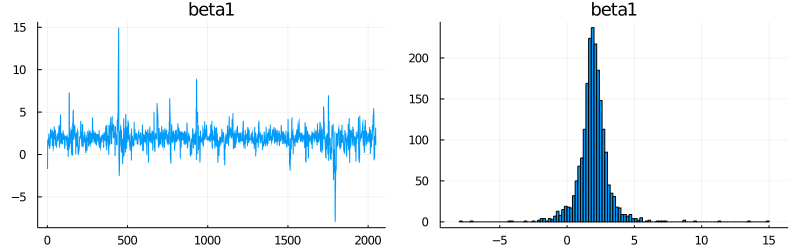

In [41]:
P1 = plot((x->x[1]).(posterior_β))
P2 = histogram((x->x[1]).(posterior_β))
plot(P1, P2, size=(800, 250), title="beta1", legend=false)

pngname = "images/001_05_beta1.png"
savefig(pngname)
showimg("image/png", pngname)

### グラフ描画 beta2


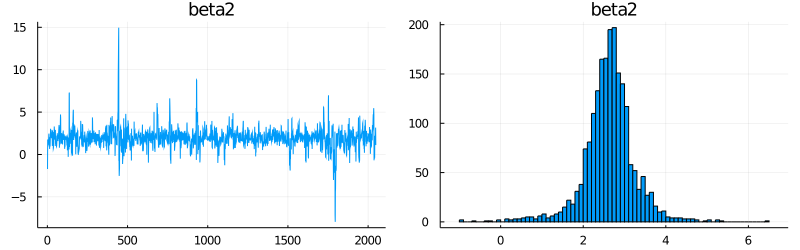

In [42]:
### グラフ描画P1 = plot((x->x[2]).(posterior_β))
P2 = histogram((x->x[2]).(posterior_β))
plot(P1, P2, size=(800, 250), title="beta2", legend=false)

pngname = "images/001_06_beta2.png"
savefig(pngname)
showimg("image/png", pngname)

### グラフ描画 beta3


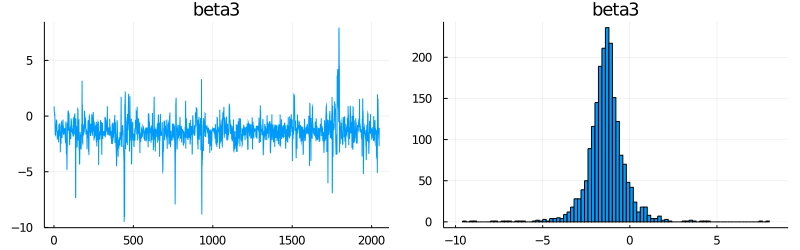

In [43]:
P1 = plot((x->x[3]).(posterior_β))
P2 = histogram((x->x[3]).(posterior_β))
plot(P1, P2, size=(800, 250), title="beta3", legend=false)

pngname = "images/001_07_beta3.png"
savefig(pngname)
showimg("image/png", pngname)

### グラフ描画 sigma


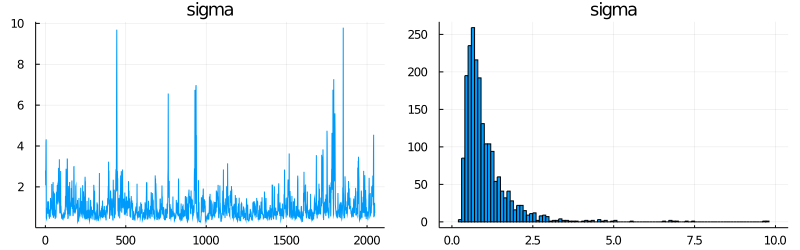

In [44]:
P1 = plot(posterior_σ)
P2 = histogram(posterior_σ)
plot(P1, P2, size=(800, 250), title="sigma", legend=false)

pngname = "images/001_08_sigma.png"
savefig(pngname)
showimg("image/png", pngname)

### 関数定義：線型回帰の事後分布

In [45]:
function pred_linreg(posterior, x, y)
    L = length(posterior)
    β = first.(posterior)
    σ = last.(posterior)
    mean(pdf(Normal(0.0, σ[i]), y - (β[i][1] + β[i][2]*x + β[i][3]*x^2)) for i in 1:L)
end

pred_linreg (generic function with 1 method)

### 最尤推定の関数定義
- `a \ b` = `inv(a) * b`
- `inv`は逆行列

In [46]:
@show a = (X'X)\X'*y
@show s = fit_mle(Normal, y - X*a).σ
pred_linreg_mle(a, s, x, y) = pdf(Normal(0.0, s), y - (a[1] + a[2]*x + a[3]*x^2))

a = ((X' * X) \ X') * y = [1.9898026341763784, 2.630342130669235, -1.4074843029322044]
s = (fit_mle(Normal, y - X * a)).σ = 0.42454239399788624


pred_linreg_mle (generic function with 1 method)

  1.622529 seconds (489.27 k allocations: 336.777 MiB, 9.60% gc time)



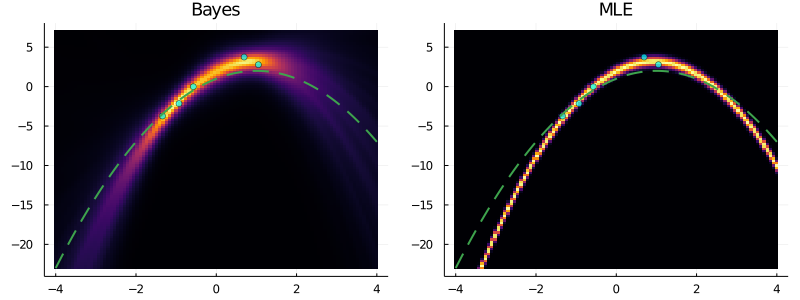

  0.106058 seconds (150.48 k allocations: 6.300 MiB, 19.38% gc time)


In [47]:
xs = range(-4, 4, length=100)
ys = range(-23, 7, length=100)

@time zs = [pred_linreg(posterior, x, y) for y in ys, x in xs]
P1 = plot(; size=(400, 300))
heatmap!(xs, ys, zs, colorbar=false)
scatter!(X[:,2], y, label="sample", legend=false, markersize=4, color=:cyan, alpha=0.7)
plot!(xs, [law_true(β, x) for x in xs], ls=:dash, lw=2)
title!("Bayes")

@time zs = [pred_linreg_mle(a, s, x, y) for y in ys, x in xs]
P2 = plot(; size=(400, 300))
heatmap!(xs, ys, zs, colorbar=false)
scatter!(X[:,2], y, label="sample", legend=false, markersize=4, color=:cyan, alpha=0.7)
plot!(xs, [law_true(β, x) for x in xs], ls=:dash, lw=2)
title!("MLE")

plot(P1, P2, size=(800, 300))

pngname = "images/001_09_comparison_bayes_mle.png"
savefig(pngname)
showimg("image/png", pngname)

### 上記グラフの解釈
[Introduction to Bayesian Statistics.ipynb](https://github.com/genkuroki/Statistics/blob/master/Introduction%20to%20Bayesian%20Statistics.ipynb)で「Bayes統計の計算例」の説明から引用します。

> 特にこのノートにおける線形回帰でベイズ統計と最尤法 (MLE)を比較しているプロットに注目. サンプルサイズが小さいせいで推定が全然収束していない状況なのに, MLE の予測分布は「くっきり」していることに注目. ベイズ統計の方の予測分布はぼやけており, 推定の収束してなさ具合がわかるようになっている.

もう少し言えば、ベイズの方はサンプルの周りは比較的「高温」で確度が高い一方、サンプルから離れたところは「低温」で確度が低く、広がりも大きくなっています。。

In [48]:
2N*mean(-log(pred_linreg(posterior, X[i,2], y[i])) for i in 1:N) 

10.56333782764278

In [49]:
2N*mean(-log(pred_linreg_mle(a, s, X[i,2], y[i])) for i in 1:N) 

5.621951230625681